In [137]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import func, distinct
from sqlalchemy.sql import label
from flask import Flask

In [77]:
import numpy as np
import pandas as pd

In [78]:
#import datetime as dt
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [79]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [80]:
#create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [81]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [82]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [83]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [84]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [85]:
#preview the first row of the Measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18f7f359248>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08}

In [130]:
#engine.execute('SELECT * FROM measurement where date >= "2016-08-01" order by date asc').fetchall()

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()

#convert string to date format
last_date = datetime.strptime(last_date, '%Y-%m-%d')

#calculate the previous year from last date
previous_year = last_date - dt.timedelta(days=366)

#query date based on previous year's date
precip = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= previous_year).\
            order_by(Measurement.date.asc()).all()

Text(0, 0.5, 'Inches')

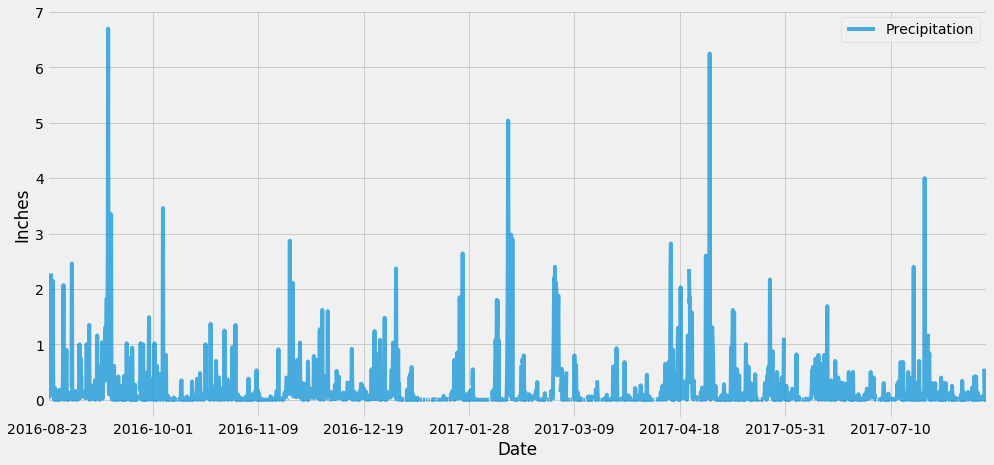

In [131]:
#plotting results from above
precip_df = pd.DataFrame(precip, columns = ['Date', 'Precipitation'])

precip_df.set_index('Date', inplace=True)
precip_df.head()
precip_df.plot(figsize = (15,7), alpha = 0.7)
plt.xlabel('Date')
plt.ylabel('Inches')

In [111]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [89]:
# Design a query to show how many stations are available in this dataset?

#preview first rows in Station table
first_row = session.query(Station).first()
first_row.__dict__

#query to calculate distinct stations in Station table
station_count = session.query(func.count(distinct(Station.station))).scalar()

#print station counts
print(f"There are {station_count} unique weather stations available in this dataset.")

There are 9 unique weather stations available in this dataset.


In [90]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#Query for the most measurements by station idea
precip = session.query(Measurement.station, func.count(Measurement.prcp)).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()

#convert query to dataframe
station_counts = pd.DataFrame(precip, columns = ['Station', 'Measurement Count'])

#sort data frame
station_counts = station_counts.sort_values(by=['Measurement Count'], ascending = False)

#print data frame
station_counts

,Station,Measurement Count
3,USC00519281,2772
0,USC00513117,2696
5,USC00519397,2685
2,USC00519523,2572
4,USC00516128,2484
7,USC00514830,1937
6,USC00511918,1932
8,USC00517948,683
1,USC00518838,342


In [91]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#assign the top station to a variable
top_station = station_counts.iloc[0,0]

#calculate min temp
min_temp = session.query(func.min(Measurement.prcp)).\
            filter(Measurement.station == top_station).scalar()

#calculate max temp
max_temp = session.query(func.max(Measurement.prcp)).\
            filter(Measurement.station == top_station).scalar()

#calculate average temp
avg_temp = session.query(func.avg(Measurement.prcp)).\
            filter(Measurement.station == top_station).scalar()

#print summary
print(f"The Min Temp for {top_station} is {min_temp}. \nThe Max Temp for {top_station} is {max_temp}. \nThe Avg Temp for {top_station} is {avg_temp}.")



The Min Temp for USC00519281 is 0.0. 
The Max Temp for USC00519281 is 9.64. 
The Avg Temp for USC00519281 is 0.2123520923520915.


Text(0, 0.5, 'Frequency')

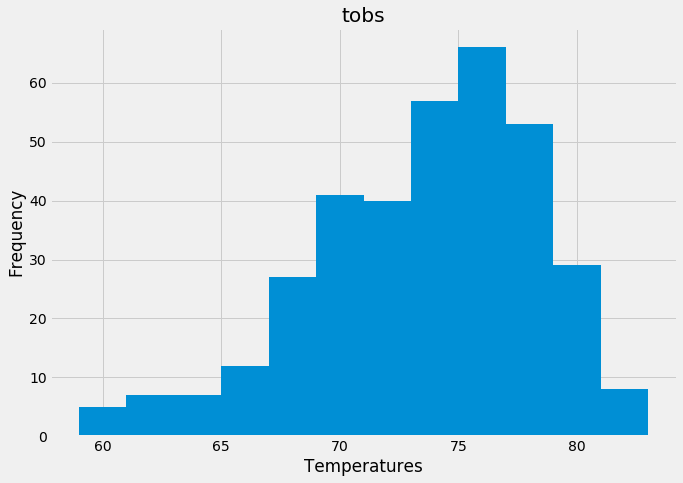

In [136]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.tobs).\
        filter(Measurement.station == top_station).\
        filter(Measurement.date >= previous_year).all()

temps_df = pd.DataFrame(temps)

temps_df.hist(bins=12,figsize = (10,7))
plt.xlabel('Temperatures')
plt.ylabel('Frequency')

## Bonus Challenge Assignment

In [93]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [94]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [95]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [96]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [97]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [98]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [99]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [100]:
# Plot the daily normals as an area plot with `stacked=False`
